In [1]:
# general imports
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator
from upt.datasets.ffs_dataset import ffsDataset

In [2]:
import random
# Set global seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# check successful setup
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))
import torchvision
print(torchvision.__version__)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr



2.5.1+cu124
NVIDIA GeForce RTX 4090
0.20.1+cu124


In [4]:

def get_datasets(
    root,
    num_train_inputs,
    num_train_outputs,
    num_test_inputs,
    num_test_outputs,
    crop_values,
    train_mode="train",
    test_mode="test",
):
    from upt.datasets.ffs_dataset import ffsDataset
    train_dataset = ffsDataset(
        root=root,
        num_inputs=num_train_inputs,
        num_outputs=num_train_outputs,
        mode=train_mode,
        crop_values=crop_values,
        deterministic=False,
    )
    test_dataset = ffsDataset(
        root=root,
        num_inputs=num_test_inputs,
        num_outputs=num_test_outputs,
        mode=test_mode,
        crop_values=crop_values,
        deterministic=True,
    )
    
    return train_dataset, test_dataset

def get_dataloaders(
    train_dataset,
    test_dataset,
    batch_size,
    num_supernodes,
):
    from torch.utils.data import DataLoader
    from upt.collators.ffs_collator import ffsCollator
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=True),
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=True),
    )
    
    return train_loader, test_loader

def get_model(dim, depth, num_heads, num_latent_tokens, radius, max_degree, conditioner_num_values,
               device, encoder_depth=None, decoder_depth=None, encoder_num_heads=None, decoder_num_heads=None, perc_num_heads=None):
    
    from upt.models.ffs_upt import ffsUPT
    from upt.models.approximator import Approximator
    from upt.models.decoder_perceiver import DecoderPerceiver
    from upt.models.encoder_supernodes import EncoderSupernodes
    from upt.models.conditioner_re import ConditionerRe

    if encoder_depth is None:
        encoder_depth = depth
    if decoder_depth is None:
        decoder_depth = depth
    if encoder_num_heads is None:
        encoder_num_heads = num_heads
    if decoder_num_heads is None:
        decoder_num_heads = num_heads
    if perc_num_heads is None:
        perc_num_heads = num_heads

    conditioner = ConditionerRe(
        dim=dim,
        num_values=conditioner_num_values,
    )
    model = ffsUPT(
        conditioner=conditioner,
        encoder=EncoderSupernodes(
            input_dim=1,
            ndim=2,
            radius=radius,
            max_degree=max_degree,
            gnn_dim=dim,
            enc_dim=dim,
            enc_num_heads=num_heads,
            enc_depth=encoder_depth,
            perc_dim=dim,
            perc_num_heads=num_heads,
            num_latent_tokens=num_latent_tokens,
            cond_dim=conditioner.cond_dim,
        ),
        approximator=Approximator(
            input_dim=dim,
            dim=dim,
            num_heads=num_heads,
            depth=depth,
            cond_dim=conditioner.cond_dim,
        ),
        decoder=DecoderPerceiver(
            input_dim=dim,
            output_dim=3,
            ndim=2,
            dim=dim,
            num_heads=num_heads,
            depth=decoder_depth,
            unbatch_mode="dense_to_sparse_unpadded",
            cond_dim=conditioner.cond_dim,
        ),
    )
    # print(f"Model architecture: dim={dim}, depth={depth}, encoder_depth={encoder_depth}, decoder_depth={decoder_depth}, num_heads={num_heads}, encoder_num_heads={encoder_num_heads}, decoder_num_heads={decoder_num_heads}, perc_num_heads={perc_num_heads}, num_latent_tokens={num_latent_tokens}")
    return model.to(device)

# def train_one_epoch(model, dataloader, optimizer, device):
#     model.train()
#     total_loss = 0.0
#     count = 0
#     for batch in dataloader:
#         optimizer.zero_grad()
#         out = model(
#             input_feat=batch["input_feat"].to(device),
#             input_pos=batch["input_pos"].to(device),
#             supernode_idxs=batch["supernode_idxs"].to(device),
#             batch_idx=batch["batch_idx"].to(device),
#             output_pos=batch["output_pos"].to(device),
#             re=batch["re"].to(device),
#         )
#         loss = F.mse_loss(out, batch["target_feat"].to(device))
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         count += 1
#     return total_loss / count if count > 0 else 0.0

# def train_one_epoch(model, dataloader, optimizer, device, accumulation_steps=1):
#     model.train()
#     total_loss = 0.0
#     count = 0
#     optimizer.zero_grad()
#     for i, batch in enumerate(dataloader):
#         out = model(
#             input_feat=batch["input_feat"].to(device),
#             input_pos=batch["input_pos"].to(device),
#             supernode_idxs=batch["supernode_idxs"].to(device),
#             batch_idx=batch["batch_idx"].to(device),
#             output_pos=batch["output_pos"].to(device),
#             re=batch["re"].to(device),
#         )
#         loss = F.mse_loss(out, batch["target_feat"].to(device))
#         loss = loss / accumulation_steps  # Scale loss
#         loss.backward()
#         if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
#             optimizer.step()
#             optimizer.zero_grad()
#         total_loss += loss.item() * accumulation_steps  # Unscale for reporting
#         count += 1
#     return total_loss / count if count > 0 else 0.0

def train_one_epoch(model, dataloader, optimizer, device, accumulation_steps=1):
    model.train()
    total_loss = 0.0
    count = 0
    step_count = 0
    optimizer.zero_grad()
    for i, batch in enumerate(dataloader):
        out = model(
            input_feat=batch["input_feat"].to(device),
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),
        )
        loss = F.mse_loss(out, batch["target_feat"].to(device)) / accumulation_steps
        loss.backward()
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()
            step_count += 1
        total_loss += loss.item() * accumulation_steps
        count += 1
        
        # Print batch size for debugging
        # print(f"Batch {i+1}/{len(dataloader)}: input_feat shape: {batch['input_feat'].shape}, target_feat shape: {batch['target_feat'].shape}, loss: {loss.item() * accumulation_steps:.4f}")
        
    return total_loss / count, step_count

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for batch in dataloader:
            out = model(
                input_feat=batch["input_feat"].to(device),
                input_pos=batch["input_pos"].to(device),
                supernode_idxs=batch["supernode_idxs"].to(device),
                batch_idx=batch["batch_idx"].to(device),
                output_pos=batch["output_pos"].to(device),
                re=batch["re"].to(device),
            )
            loss = F.mse_loss(out, batch["target_feat"].to(device))
            total_loss += loss.item()
            count += 1
    return total_loss / count if count > 0 else 0.0

# RANS FFS

Optuna Hyperparameter Optimization

In [11]:
import optuna


epochsHPO = 1000

def objective(trial):
    # Sample hyperparameters
    dim = trial.suggest_categorical("dim", [128, 256, 512])
    depth = trial.suggest_categorical("depth", [1, 2, 4])
    encoder_depth = trial.suggest_categorical("encoder_depth", [1, 2, 4])
    # decoder_depth = trial.suggest_categorical("decoder_depth", [1, 2
    decoder_depth = encoder_depth    
    num_heads = trial.suggest_categorical("num_heads", [1, 2, 4])
    encoder_num_heads = trial.suggest_categorical("encoder_num_heads", [1, 2, 4])
    # decoder_num_heads = trial.suggest_categorical("decoder_num_heads", [2, 4])
    decoder_num_heads = encoder_num_heads
    perc_num_heads = trial.suggest_categorical("perc_num_heads", [1, 2, 4])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [25, 50])
    # batch_size = trial.suggest_categorical("batch_size", [50])
    accumulation_steps = trial.suggest_categorical("accumulation_steps", [1, 2])
    num_supernodes = trial.suggest_categorical("num_supernodes", [256, 512, 1024])
    num_latent_tokens = trial.suggest_categorical("num_latent_tokens", [256, 512, 1024])
    # num_inputs = trial.suggest_categorical("num_inputs", [2048, 4096, 8192])
    # num_outputs = trial.suggest_categorical("num_outputs", [2048, 4096, 8192])

    # max_degree
    # radius
    
    # dataset parameters
    root = "./data/ffs/preprocessed/SST"
    crop_values = [[-5, -2], [5, 2]]
    radius = 5
    max_degree = 32
    num_train_inputs = 4096
    num_train_outputs = 4096
    num_test_inputs = 4096
    num_test_outputs = 4096
    # batch_size = 50
    weight_decay = 0.05

    # Datasets and loaders
    train_dataset, test_dataset = get_datasets(
        root=root,
        num_train_inputs=num_train_inputs,
        num_train_outputs=num_train_outputs,
        num_test_inputs=num_test_inputs,
        num_test_outputs=num_test_outputs,
        crop_values=crop_values,
    )
    train_loader, test_loader = get_dataloaders(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        batch_size=batch_size,
        num_supernodes=num_supernodes,
    )

    # Model
    model = get_model(
        dim=dim,
        depth=depth,
        num_heads=num_heads,
        num_latent_tokens=num_latent_tokens,
        radius=radius,
        max_degree=max_degree,
        conditioner_num_values=train_dataset.num_values,
        device=device,
        encoder_depth=encoder_depth,
        decoder_depth=decoder_depth,
        encoder_num_heads=encoder_num_heads,
        decoder_num_heads=decoder_num_heads,
        perc_num_heads=perc_num_heads,
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # # Learning rate schedule
    # total_updates = len(train_loader) * epochsHPO
    # warmup_updates = int(total_updates * 0.1)
    # lrs = torch.concat([
    #     torch.linspace(0, lr, warmup_updates),
    #     torch.linspace(lr, 0, total_updates - warmup_updates),
    # ])
    
    total_updates = int((len(train_loader) / accumulation_steps) * epochsHPO)
    print(f"Total updates: {total_updates}, Batch Size: {batch_size}, Length Trainloader: {len(train_loader)}, Accumulation steps: {accumulation_steps}, Epochs: {epochsHPO}")
    warmup_updates = int(total_updates * 0.1)
    lrs = torch.concat([
        torch.linspace(0, lr, warmup_updates),
        torch.linspace(lr, 0, total_updates - warmup_updates),
    ])



    wandb.init(
        project="UPT-HPO4",
        name=f"trial_{trial.number}",
        # config={
        #     "dim": dim,
        #     "depth": depth,
        #     "encoder_depth": encoder_depth,
        #     "decoder_depth": decoder_depth,
        #     "num_heads": num_heads,
        #     "encoder_num_heads": encoder_num_heads,
        #     "decoder_num_heads": decoder_num_heads,
        #     "perc_num_heads": perc_num_heads,
        #    # "num_inputs": num_inputs,
        #    # "num_outputs": num_outputs,
        #     "lr": lr,
        #     "batch_size": batch_size,
        #     "grad_accumulation_steps": accumulation_steps,
        #     "num_supernodes": num_supernodes,
        #     "num_latent_tokens": num_latent_tokens,
        # },
        config=trial.params,
        reinit=True
    )
    try:
        update = 0
        best_val_loss = float("inf")
        for epoch in range(epochsHPO):
            for param_group in optimizer.param_groups:
                param_group["lr"] = lrs[update]
            # train_loss = train_one_epoch(
            #     model, train_loader, optimizer, device, accumulation_steps=accumulation_steps
            # )
            train_loss, step_count = train_one_epoch(model, train_loader, optimizer, device, accumulation_steps)
            update += step_count
            val_loss = evaluate(model, test_loader, device)
            best_val_loss = min(best_val_loss, val_loss)
            wandb.log({
                "train_loss": train_loss,
                "test_loss": val_loss,
                "learning_rate": optimizer.param_groups[0]["lr"],
                # "accumulation_steps": accumulation_steps,
            })
            # update += len(train_loader)
            trial.report(val_loss, step=epoch)
            if epoch > 300 and trial.should_prune():
                wandb.finish()
                raise optuna.TrialPruned()
        wandb.finish()
        return best_val_loss
    
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"Trial {trial.number} pruned due to OOM.")
            wandb.finish()
            raise optuna.exceptions.TrialPruned()
        elif 'dim should be divisible by num_heads' in str(e):
            print(f"Trial {trial.number} pruned due to incompatible dimensions.")
            wandb.finish()
            raise optuna.exceptions.TrialPruned()    
        else:
            raise e  # re-raise other errors

# Define Optuna study with conservative pruning
from optuna.pruners import MedianPruner
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=300, interval_steps=10)

# study = optuna.create_study(direction="minimize", pruner=pruner)
study = optuna.create_study(direction="minimize", pruner=pruner, storage="sqlite:///ffs_hpo4_val.db", load_if_exists=True)

# study.enqueue_trial({
#     "dim": 128,
#     "num_heads": 2,
#     "depth": 4,
#     "num_latent_tokens": 512,
#     "lr": 7.36308743518061e-05, 
#     "num_supernodes": 1024,
#     "batch_size": 50,
#     "accumulation_steps": 1,
#     "encoder_depth": 4,
#     "encoder_num_heads": 2,
#     "perc_num_heads": 2,
# })

study.enqueue_trial({
    "dim": 128,
    "num_heads": 4,
    "depth": 1,
    "num_latent_tokens": 1024,
    "lr": 0.0004885, 
    "num_supernodes": 1024,
    "batch_size": 25,
    "accumulation_steps": 1,
    "encoder_depth": 1,
    "encoder_num_heads": 2,
    "perc_num_heads": 1,
})

study.optimize(objective, n_trials=1)

print("Best trial:")
print(study.best_trial)

[I 2025-07-17 15:24:29,771] A new study created in RDB with name: no-name-08c8a8d8-78cb-4f48-b3ee-2db32b850a51
/tmp/ipykernel_934/2932003303.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Model parameters: 3501827
Total updates: 20000, Batch Size: 25, Length Trainloader: 20, Accumulation steps: 1, Epochs: 1000


learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
test_loss,█▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
test_loss,0.01074
train_loss,0.00261


[I 2025-07-17 17:31:31,934] Trial 0 finished with value: 0.010617728810757399 and parameters: {'dim': 128, 'depth': 1, 'encoder_depth': 1, 'num_heads': 4, 'encoder_num_heads': 2, 'perc_num_heads': 1, 'lr': 0.0004885, 'batch_size': 25, 'accumulation_steps': 1, 'num_supernodes': 1024, 'num_latent_tokens': 1024}. Best is trial 0 with value: 0.010617728810757399.


Best trial:
FrozenTrial(number=0, state=1, values=[0.010617728810757399], datetime_start=datetime.datetime(2025, 7, 17, 15, 24, 29, 801712), datetime_complete=datetime.datetime(2025, 7, 17, 17, 31, 31, 855166), params={'dim': 128, 'depth': 1, 'encoder_depth': 1, 'num_heads': 4, 'encoder_num_heads': 2, 'perc_num_heads': 1, 'lr': 0.0004885, 'batch_size': 25, 'accumulation_steps': 1, 'num_supernodes': 1024, 'num_latent_tokens': 1024}, user_attrs={}, system_attrs={'fixed_params': {'dim': 128, 'num_heads': 4, 'depth': 1, 'num_latent_tokens': 1024, 'lr': 0.0004885, 'num_supernodes': 1024, 'batch_size': 25, 'accumulation_steps': 1, 'encoder_depth': 1, 'encoder_num_heads': 2, 'perc_num_heads': 1}}, intermediate_values={0: 1.1769102573394776, 1: 1.1041170835494996, 2: 1.011251986026764, 3: 0.8778327226638794, 4: 0.6765295267105103, 5: 0.5255443513393402, 6: 0.45168893337249755, 7: 0.4140674710273743, 8: 0.3744859218597412, 9: 0.3499576926231384, 10: 0.3237599730491638, 11: 0.32061424255371096, 

In [7]:
print(study.best_trial)

FrozenTrial(number=18, state=1, values=[0.006622223493953546], datetime_start=datetime.datetime(2025, 6, 16, 9, 58, 53, 256930), datetime_complete=datetime.datetime(2025, 6, 16, 11, 58, 34, 682938), params={'dim': 128, 'depth': 4, 'num_heads': 2, 'lr': 0.0006365937629779673, 'weight_decay': 7.36308743518061e-05, 'num_supernodes': 1024, 'num_latent_tokens': 256}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.1410367886225383, 1: 1.0983720223108928, 2: 1.0348243316014607, 3: 0.96010422706604, 4: 0.8429580132166544, 5: 0.6806403795878092, 6: 0.5564627051353455, 7: 0.4939002792040507, 8: 0.45448020100593567, 9: 0.42598962783813477, 10: 0.3995142877101898, 11: 0.3769892950852712, 12: 0.35680004954338074, 13: 0.3372972309589386, 14: 0.31557119886080426, 15: 0.30712013443311054, 16: 0.3069361944993337, 17: 0.2861922085285187, 18: 0.27604997158050537, 19: 0.2717659076054891, 20: 0.28614572683970135, 21: 0.27759193380673725, 22: 0.26528961956501007, 23: 0.26259591182072956, 24: 0.26

In [5]:
dim = 128
num_heads = 4
radius = 5
max_degree=32
depth=1
encoder_depth=1
encoder_num_heads = 2
decoder_depth = encoder_depth
decoder_num_heads = encoder_num_heads
num_latent_tokens=1024
perc_num_heads = 1

# hyperparameters training
learning_rate = 0.0004885 # 1e-4
weight_decay=0.05
num_supernodes = 1024
epochs = 1000
batch_size = 25
num_train_inputs  = 4096
num_train_outputs = 4096
accumulation_steps = 1

runID = 'best_HPO4_deterministicLoader_r1'

Datasets

In [6]:
root = "./data/ffs/preprocessed/SST"
crop_values = [[-5, -2], [5, 2]]
num_test_inputs  = 4096
num_test_outputs = 4096

train_dataset, test_dataset = get_datasets(
    root=root,
    num_train_inputs=num_train_inputs,
    num_train_outputs=num_train_outputs,
    num_test_inputs=num_test_inputs,
    num_test_outputs=num_test_outputs,
    crop_values=crop_values,
)

train_dataloader, test_dataloader = get_dataloaders(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=batch_size,
    num_supernodes=num_supernodes,
)

Model

In [7]:
# model = get_model(
#     dim=dim,
#     depth=depth,
#     num_heads=num_heads,
#     num_latent_tokens=num_latent_tokens,
#     radius=radius,
#     max_degree=max_degree,
#     conditioner_num_values=train_dataset.num_values,
#     device=device,
# )

# Model
model = get_model(
    dim=dim,
    depth=depth,
    num_heads=num_heads,
    num_latent_tokens=num_latent_tokens,
    radius=radius,
    max_degree=max_degree,
    conditioner_num_values=train_dataset.num_values,
    device=device,
    encoder_depth=encoder_depth,
    decoder_depth=encoder_depth,
    encoder_num_heads=encoder_num_heads,
    decoder_num_heads=encoder_num_heads,
    perc_num_heads=perc_num_heads,
)

print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")



parameters: 3.5M


WandB Init

In [8]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="battlejacket-liu",
    name=runID,
    # Set the wandb project where this run will be logged.
    project="UPT-HPO4",
    # Track hyperparameters and run metadata.
    config={
        # "learning_rate": learning_rate,
        # "dataset": "ffs",
        # "epochs": epochs,
        # "num_test_inputs": num_test_inputs,
        # "num_test_outputs": num_test_outputs,
        # "num_train_inputs": num_train_inputs,
        # "num_train_outputs": num_train_outputs,
        # "dim": dim,
        # "num_heads": num_heads,
        # "batch_size": batch_size,
        # "weight_decay": weight_decay,
        # "num_supernodes": num_supernodes,
        # "depth": depth,
        # "encoder_radius": radius,
        # "encoder_max_degree": max_degree,
        # "encoder_num_latent_tokens": num_latent_tokens,  
        "dim": dim,
        "depth": depth,
        "encoder_depth": encoder_depth,
        "num_heads": num_heads,
        "encoder_num_heads": encoder_num_heads,
        "perc_num_heads": perc_num_heads,
        "lr": learning_rate,
        "batch_size": batch_size,
        "grad_accumulation_steps": accumulation_steps,
        "num_supernodes": num_supernodes,
        "num_latent_tokens": num_latent_tokens,
    },
)

wandb: Currently logged in as: battlejacket (battlejacket-liu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Train Model

In [9]:
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# total_updates = len(train_dataloader) * epochs
# warmup_updates = int(total_updates * 0.1)
# lrs = torch.concat([
#     torch.linspace(0, optim.defaults["lr"], warmup_updates),
#     torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
# ])

total_updates = int((len(train_dataloader) / accumulation_steps) * epochs)
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat([
    torch.linspace(0, learning_rate, warmup_updates),
    torch.linspace(learning_rate, 0, total_updates - warmup_updates),
])

update = 0
pbar = tqdm(total=total_updates)
test_loss = None
for epoch in range(epochs):
    # Set learning rate
    for param_group in optim.param_groups:
        param_group["lr"] = lrs[update]
    # train_loss = train_one_epoch(model, train_dataloader, optim, device)
    train_loss, step_count = train_one_epoch(model, train_dataloader, optim, device, accumulation_steps)
    update += step_count
    test_loss = evaluate(model, test_dataloader, device)
    pbar.update(len(train_dataloader))
    pbar.set_description(f"train_loss: {train_loss:.4f} test_loss: {test_loss:.4f}")
    wandb.log({
        "train_loss": train_loss,
        "test_loss": test_loss,
        "learning_rate": optim.param_groups[0]["lr"],
    })
    # update += len(train_dataloader)
pbar.close()
wandb.finish()

train_loss: 0.0023 test_loss: 0.0304: 100%|██████████| 20000/20000 [2:18:47<00:00,  2.40it/s]  


learning_rate,▂▄▆██▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
test_loss,█▅▃▃▄▄▃▄▃▂▂▂▂▃▁▂▂▅▁▂▂▂▁▁▂▁▂▂▂▄▂▂▂▂▃▃▃▄▄▄
train_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
test_loss,0.0304
train_loss,0.00232


Save Model

In [21]:
path = 'save/' + runID + '.pth'
torch.save(model.state_dict(), path)
# wandb.save('save/sdf_model.pth')

Test and Inference

In [ ]:
# load model
path = 'save/' + runID + '.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.eval()

NameError: name 'runID' is not defined

In [ ]:
# crop_values_test= [[-2, -2], [0, 2]]

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessedSST",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=10000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=10000,
    # mode
    mode="test",
    crop_values=crop_values,
    useMesh='modify',
    use_inferencer_inputs=False
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_hr_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)
data = [d for d in test_hr_dataloader]

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x720cdad9a050>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 720cc011edd0, raw_cell="# crop_values_test= [[-2, -2], [0, 2]]

test_hr_da.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://attached-container%2B7b22636f6e7461696e65724e616d65223a222f61646d6972696e675f626f7267227d@ssh-remote%2B10.245.2.189/workspace/upt-tutorial/ffsRans.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x720cdad9a050>> (for post_run_cell), with arguments args (<ExecutionResult object at 720c9839d950, execution_count=10 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 720cc011edd0, raw_cell="# crop_values_test= [[-2, -2], [0, 2]]

test_hr_da.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://attached-container%2B7b22636f6e7461696e65724e616d65223a222f61646d6972696e675f626f7267227d@ssh-remote%2B10.245.2.189/workspace/upt-tutorial/ffsRans.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
test_batch = data[0]
name = test_batch['name'][0]
paramDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from data.ffs.readParameters import readParametersFromFileName
parameters = readParametersFromFileName(name, paramDef)
re = parameters['re']
Lo = parameters['Lo']
Ho = parameters['Ho']

In [ ]:
# make predictions

with torch.no_grad():
    y_hat = model(
        input_feat=test_batch["input_feat"].to(device),
        input_pos=test_batch["input_pos"].to(device),
        # input_pos=test_hr_dataset.denormalize_pos(points).to(device),
        supernode_idxs=test_batch["supernode_idxs"].to(device),
        batch_idx=test_batch["batch_idx"].to(device),
        output_pos=test_batch["output_pos"].to(device),
        re=test_batch["re"].to(device),
    )

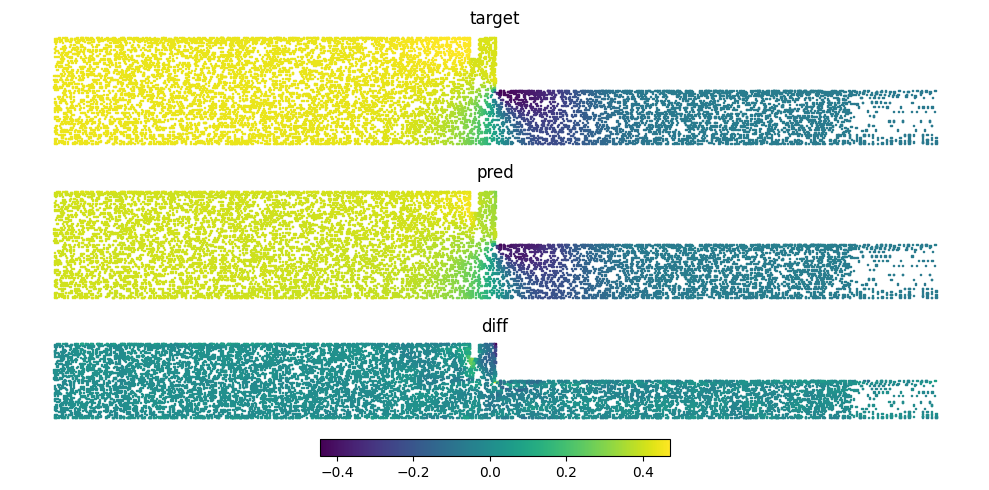

In [ ]:
# generated input vs target
points = test_hr_dataset.denormalize_pos(test_batch["output_pos"].squeeze(0))
pred_all = test_hr_dataset.denormalize_feat(y_hat.cpu())

feature_idx = 2

x_pos, y_pos = points.unbind(1)
pred = pred_all[:,feature_idx]
target_all = test_hr_dataset.denormalize_feat(test_batch["target_feat"]) #[:10000]
target = target_all[:,feature_idx]


_, axes = plt.subplots(3, 1, figsize=(10, 5)) #, figsize=(10, 2)
axes[0].scatter(x_pos, y_pos, c=target, marker="s", s=1)
axes[0].set_title("target")
axes[0].set_axis_off()
axes[1].scatter(x_pos, y_pos, c=pred, marker="s", s=1)
axes[1].set_title("pred")
axes[1].set_axis_off()
scatter_diff = axes[2].scatter(x_pos, y_pos, c=pred-target, marker="s", s=1)
axes[2].set_title("diff")
axes[2].set_axis_off()
plt.colorbar(scatter_diff, ax=axes[2], orientation="horizontal")
plt.tight_layout()
# plt.colorbar()
# plt.title(test_batch["name"])
plt.show()

In [ ]:
from data.ffs.readParameters import readParametersFromFileName
parameterDef = {'name': str, 're': float, 'Lo': float, 'Ho': float, 'dCp': float}


test_losses = []
dp = []
loss = None
test_loss = None
# # evaluate
test_loss = 0.
for batch in test_hr_dataloader:
    with torch.no_grad():
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            # input_feat=None,
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),
        )
    y = batch["target_feat"].to(device)
    test_loss = (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
    test_losses.append(test_loss)
    dp.append(readParametersFromFileName(batch['name'][0], parameterDef))
    dp[-1]['mse'] = test_loss
test_losses = np.array(test_losses)


In [ ]:
sorted_mse = sorted(dp, key=lambda x: x['mse'])

In [ ]:
dp

[{'name': 'DP843',
  're': 27558.33333333334,
  'Lo': 0.28333333333333327,
  'Ho': 0.20100000000000026,
  'dCp': 4.26151,
  'mse': 0.0043103452771902084},
 {'name': 'DP781',
  're': 29074.99999999999,
  'Lo': 0.9073333333333389,
  'Ho': 0.159,
  'dCp': 3.95904,
  'mse': 0.005758475977927446},
 {'name': 'DP780',
  're': 31625.00000000002,
  'Lo': 0.621999999999999,
  'Ho': 0.15833333333333333,
  'dCp': 4.06077,
  'mse': 0.0031971950083971024},
 {'name': 'DP919',
  're': 34041.666666666744,
  'Lo': 0.4193333333333336,
  'Ho': 0.25166666666666637,
  'dCp': 3.9143,
  'mse': 0.005122424568980932},
 {'name': 'DP1163',
  're': 25808.333333333332,
  'Lo': 0.5673333333333321,
  'Ho': 0.4143333333333352,
  'dCp': 3.7418,
  'mse': 0.019779957830905914},
 {'name': 'DP801',
  're': 31275.000000000007,
  'Lo': 0.6966666666666673,
  'Ho': 0.1730000000000001,
  'dCp': 3.97677,
  'mse': 0.005198546219617128},
 {'name': 'DP1143',
  're': 25641.666666666668,
  'Lo': 0.35133333333333355,
  'Ho': 0.4010000

In [ ]:
test_loss = np.mean(test_losses)
print(f"test_loss: {test_loss:.4f} ")

test_loss: 0.0064 


In [ ]:
test_dataset_grid = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=10000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=10000,
    # mode
    mode="test",
    crop_values=crop_values,
    useMesh=None,
    use_inferencer_inputs=False
)

In [ ]:
from ffsInference import ffsInference

inferencer = ffsInference(
    base_dataset=test_dataset_grid,
    numSupernodes=1024,
    model=model,
    device=device,
)

In [ ]:
from forwardFacingStep.optimization import deltaCp
from scipy.stats import spearmanr
import pandas as pd

# Load the CSV file
df = pd.read_csv('forwardFacingStep/dataset600.csv')

# Extract the desired columns
selected_columns = ['P4 - Re', 'P6 - Ob_pos [m]', 'P7 - Ob_H [m]', 'P1 - Delta Cp']
dCp_valDesigns = df[selected_columns].to_numpy()

deltaCp = deltaCp()
output_pos = deltaCp.outputPositions()
parameter_sets = dCp_valDesigns[:,:-1]
dCp_true = dCp_valDesigns[:,-1]

#infer using design[:,:-1]
results = inferencer.infer(parameter_sets=parameter_sets, output_pos=output_pos, batch_size=5)
predictions = results['predictions']
dCp_pred = deltaCp.calculateDeltaCp(predictions=predictions)

#compare with design[:,-1]
# Compute Spearman's rank correlation coefficient and p-value
rho, p_value = spearmanr(dCp_pred, dCp_true)
print(f"Spearman's rho: {rho:.3f}, p-value: {p_value:.3g}")

KeyboardInterrupt: 

In [ ]:
import copy
test_hr_dataset_dCp = copy.deepcopy(test_hr_dataset)
test_hr_dataset_dCp.customOutputPos = output_pos
test_hr_dataset_dCp.use_inferencer_inputs = True

test_dataloader_dCp = DataLoader(
    dataset=test_hr_dataset_dCp,
    batch_size=5,
    collate_fn=ffsCollator(num_supernodes=1024, deterministic=True),
)

train_losses = []
test_losses = []
loss = None
test_loss = None
# # evaluate
test_loss = 0.

all_predictions = []
all_true = []


for batch in test_dataloader_dCp:
    with torch.no_grad():
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            # input_feat=None,
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),
        )
    all_predictions.append(test_hr_dataset.denormalize_feat(y_hat.cpu()))
    all_true.append(batch['dCp'])

# Concatenate predictions and points across batches
all_predictions = torch.cat(all_predictions, dim=0)
all_true = torch.cat(all_true, dim=0)

dCp_pred = deltaCp.calculateDeltaCp(predictions=all_predictions)
dCp_true = all_true

# Compute Spearman's rank correlation coefficient and p-value
rho, p_value = spearmanr(dCp_pred, dCp_true)
print(f"Spearman's rho: {rho:.3f}, p-value: {p_value:.3g}")

base mesh set
Spearman's rho: 0.996, p-value: 2.98e-125


In [ ]:
import numpy as np
import time
import os
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination.default import DefaultMultiObjectiveTermination
from forwardFacingStep.optimization import ffsOptProblem

param_ranges = {
    'Re': (100, 1000),
    'Lo': (0.2, 1),
    'Ho': (0.1, 0.5),
    }



xl=np.array([float(param_ranges['Lo'][0]),float(param_ranges['Ho'][0])])
xu=np.array([float(param_ranges['Lo'][1]),float(param_ranges['Ho'][1])])

# inferencer = ffsInference(
#     train_dataset=test_hr_dataset,
#     totalPoints=40000,
#     numSupernodes=512,
    
# )

optResultsPath = "./optimizationResults/"

optPath = optResultsPath

# reRange = [600]
reRange = range(100,1100,100)
print('defining problem')

# problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu, inferencer=inferencer, maxDesignsPerEvaluation=500)


for re in reRange:

    if os.path.exists(optPath + "/optResultsX" + str(re) + ".npy"):
        print("skipping ", optPath + " " + str(re))
        continue
    
    optStartTime = time.time()
    
    # print("Optimizing: ", str(model) + " " + str(re))
    print("Optimizing: " + str(re))
    
    # problem.re = re 
    problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu,
                inferencer=inferencer, re=re, maxDesignsPerEvaluation=500)
    algorithm = DE(pop_size=200)

    termination = DefaultMultiObjectiveTermination(
        n_max_gen=1000, # default 1000
        n_max_evals=10000000
    )

    # results = minimize(problem=problem, algorithm=algorithm,termination=termination)


    # print("Optimization Done in ", time.time() - optStartTime)
    # print("Best Design Objective Value: ", results.F)
    # print("Best Design Parameter Value: ", results.X)

defining problem
Optimizing: 100
Optimizing: 200
Optimizing: 300
Optimizing: 400
Optimizing: 500
Optimizing: 600
Optimizing: 700
Optimizing: 800
Optimizing: 900
Optimizing: 1000


In [ ]:
designs = []
for i in range(3):
    designs.append([600, 0.32, 0.39])
designs = np.array(designs)

In [ ]:
# Discrete/Continuous Re, Lo, Ho, dCp, dCp^ref, ddCp
# 600 0.32 0.39 9.94 10.33 0.39
# 600 0.36 0.38 9.94 10.33 0.39

# designs = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38]])
# designs = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38], [700, 0.36, 0.38], [800, 0.36, 0.38]])

allDesigns = designs[:, 1:]
out = {}

prediction = problem._evaluate(allDesigns, out)

Evaluation time: 0.18 seconds
